In [1]:
from pyswarm import pso

from os import path
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import os

import numpy as np
import pandas as pd
import time
import random
from math import sqrt 
import random
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Cropping1D, Cropping2D, TimeDistributed, Dense, Dropout, LSTM, Conv1D, Flatten, Activation, MaxPooling1D
from json import loads
from scipy.ndimage.filters import uniform_filter1d
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow
import matplotlib.pyplot as plt 
import re
from util import *
from tqdm import tqdm

<ipython-input-1-21140ef926ab>:21: DeprecationWarning: Please use `uniform_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import uniform_filter1d


In [2]:
from skopt.space import Categorical, Real
from skopt.utils import use_named_args
from skopt import gp_minimize

In [3]:
def truncate(n, decimals=0):
    multiplier = 10 ** decimals
    return int(n * multiplier) / multiplier

def hasLSTM(model):
	firstlayer=model.layers[0].name[:4]
	if(firstlayer=='lstm'):
		answer=True
	else:
		answer=False
	return answer

def hasCONV1D(model):
	firstlayer=model.layers[0].name[:6]
	if(firstlayer=='conv1d'):
		answer=True
	else:
		answer=False
	return answer

def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		if out_end_ix > len(sequences):
			break
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

def metrics(model, X_test, y_test_3d, scaler, cpu_user_col, cpu_system_col, cpu_idle_col, ram_col):#, upload_col, label_col):
  
  global lookahead

  
  results_dict = {'cpu_user_time_diff_observations':[], 'cpu_user_time_diff_predicted_observations':[], 'cpu_user_time_diff_mae':[], 'cpu_user_time_diff_rmse':[],
   'cpu_system_time_diff_observations':[], 'cpu_system_time_diff_predicted_observations':[],  'cpu_system_time_diff_mae':[], 'cpu_system_time_diff_rmse':[],
    'cpu_idle_time_diff_observations':[], 'cpu_idle_time_diff_predicted_observations':[],  'cpu_idle_time_diff_mae':[], 'cpu_idle_time_diff_rmse':[],
     'memory_observations':[], 'memory_predicted_observations':[], 'memory_mae':[], 'memory_rmse':[]}
     #,'net_sent_diff_observations':[], 'net_sent_diff_predicted_observations':[], 'net_sent_diff_mae':[], 'net_sent_diff_rmse':[]}
     #,'label_observations':[], 'label_predicted_observations':[], 'label_mae':[], 'label_rmse':[]}
  
  prediction_3d = model.predict(X_test)
  
  iter_list = [('cpu_user_time_diff',cpu_user_col), ('cpu_system_time_diff',cpu_system_col),('cpu_idle_time_diff',cpu_idle_col),('memory',ram_col)]#,('net_sent_diff',upload_col),('label',label_col)]

  for feature_name, feature_col in iter_list:
    print(feature_name)

    if model_type == 'with conv--':
      y_test_3d = y_test_3d.reshape(y_test_3d.shape[0],lookahead,X_test.shape[2])
      prediction_3d = prediction_3d.reshape(prediction_3d.shape[0],lookahead,X_test.shape[2])
    
    for row in tqdm(range(len(y_test_3d))):

      y_test=scaler.inverse_transform(y_test_3d[row,:,:])
      prediction=scaler.inverse_transform(prediction_3d[row,:,:])

      results_dict[feature_name+'_observations'].append(y_test[:,feature_col].tolist())
      prds = [0 if i < 0 else i for i in prediction[:,feature_col].tolist()]

      results_dict[feature_name+'_predicted_observations'].append(prds)
      results_dict[feature_name+'_rmse'].append(sqrt(mean_squared_error(y_test[:,feature_col], prds)))
      results_dict[feature_name+'_mae'].append(mean_absolute_error(y_test[:,feature_col], prds)) 

  


      
  
  return results_dict


def inference(model, X, pred_loc, pred_shift):
  #i=random.randrange(len(X))	
  startS=time.time()	
  prediction=model.predict(X[[pred_loc]])	
  timeS=time.time()-startS
  #i=random.randrange(len(X)-pred_shift)
  input = X[pred_loc:pred_loc+pred_shift+1]
  startB=time.time()
  batch_prediction=model.predict(input)
  timeB=time.time()-startB
  return timeS, timeB

def data_preparation(datasetfile, drop_list):
  dataframe = pd.read_csv(datasetfile, engine='python')
  
  if 'time_stamp' in dataframe.columns:
    dataframe = dataframe.drop(drop_list, axis=1)  
  
  cpu_user_column = dataframe.columns.get_loc("cpu_user_time_diff")
  cpu_system_column = dataframe.columns.get_loc("cpu_system_time_diff")
  cpu_idle_column = dataframe.columns.get_loc("cpu_idle_time_diff")
  ram_column = dataframe.columns.get_loc("memory")
  #upload_column = dataframe.columns.get_loc("net_sent_diff")
  #label_column = dataframe.columns.get_loc("label")

  dataframe = dataframe.fillna(0)
  dataset = dataframe.values
  dataset = np.nan_to_num(dataset)
  dataset = dataset.astype('float32')
  #scaler = MinMaxScaler(feature_range=(0, 1))
  scaler = MaxAbsScaler()
  scaler.fit(dataset)
  dataset = scaler.transform(dataset)
  return dataset, scaler, cpu_user_column, cpu_system_column, cpu_idle_column, ram_column#, upload_column, label_column

def remove_dupes(i, o):
	for j in range(len(i)):
		for k in range(len(i)):
			if (i[j]==i[k] and j!=k):
				if (o[j]>o[k]):
					i.pop(j)
					o.pop(j)
					return remove_dupes(i, o)
				else:
					i.pop(k)
					o.pop(k)
					return remove_dupes(i, o)
	return i, o

def train_test(model, dataset, lookback, lookahead, split, model_type):
  if hasLSTM(model) or hasCONV1D(model):
    dataset,datasetY=split_sequences(dataset,lookback,lookahead)
    if model_type == 'with lstm':
      datasetY=datasetY.reshape(datasetY.shape[0],datasetY.shape[1],datasetY.shape[2]) 
    elif model_type == 'with conv':
      datasetY=datasetY.reshape(datasetY.shape[0],datasetY.shape[2]*datasetY.shape[1]) 
  else: # not used 
    dataset,datasetY=split_sequences(dataset,1,1)  
    dataset=dataset.reshape(dataset.shape[0],dataset.shape[2])
    datasetY=datasetY.reshape(datasetY.shape[0],datasetY.shape[2])  
  train_size = int(len(dataset) * split)
  #test_size = len(dataset) - train_size
  trainX, testX = dataset[0:train_size,:], dataset[train_size:,:]
  trainY, testY = datasetY[0:train_size,:], datasetY[train_size:,:] 
  return trainX, testX, trainY, testY

def getOptimizer(x4, optimizer):
  learning_rate = x4
  if optimizer =='RMSprop':
    optimizer = tensorflow.keras.optimizers.RMSprop(learning_rate=learning_rate)
  elif optimizer =='Adam':
    optimizer = tensorflow.keras.optimizers.Adam(learning_rate=learning_rate)
  elif optimizer =='SGD':
    optimizer = tensorflow.keras.optimizers.SGD(learning_rate=learning_rate)
  elif optimizer =='Adagrad':
    optimizer = tensorflow.keras.optimizers.Adagrad(learning_rate=learning_rate)
  elif optimizer =='Adadelta':
    optimizer = tensorflow.keras.optimizers.Adadelta(learning_rate=learning_rate)
  elif optimizer =='Adamax':
    optimizer = tensorflow.keras.optimizers.Adamax(learning_rate=learning_rate)
  else:
    optimizer = tensorflow.keras.optimizers.Nadam(learning_rate=learning_rate)

  return optimizer

def build_model(activationFunction, optimizer, pred_type):
  global dataset, defineModel, lookback, lookahead, neurons, numOfLayers, dropout, noOfLSTM_CONV, pool_size
  
  """
  if defineModel == False:
    defineModel = True
    models = ['with lstm', 'with conv']
    typeOfModel = random.choice(models)
  """
  typeOfModel = random.choice(['with lstm', 'with conv'])
  model = Sequential()
  neurons = int(round(x0))
  numOfLayers = int(round(x1))
  dropout = truncate(x3,1)
  lookback = int(round(x2))
  optimization = getOptimizer(x4, optimizer)
  noOfLSTM_CONV = int(round(x7))
  pool_size = int(round(x8))
  
  
 
  if typeOfModel == 'with lstm':
    for i in range(1,noOfLSTM_CONV+1):
        if i == 1:
            model.add(LSTM(neurons, input_shape=(lookback, dataset.shape[1]), activation=activationFunction, recurrent_activation='sigmoid', implementation=2, return_sequences=True))
        else:
            model.add(LSTM(neurons,activation=activationFunction, recurrent_activation='sigmoid', implementation=2, return_sequences=True)) 
  
    units = neurons
    for i in range(1,numOfLayers+1):
        units = int(round(units/2))
        if units > 0:    
          model.add(TimeDistributed(Dense(units, activation=activationFunction)))
          model.add(TimeDistributed(Dropout(dropout)))

    model.add(TimeDistributed(Dense(dataset.shape[1])))

    model.add(Cropping1D(cropping=(lookback-lookahead,0)))


  elif typeOfModel == 'with conv':
    for i in range(1,noOfLSTM_CONV+1):
        if i == 1:
            model.add(Conv1D(filters=neurons, kernel_size=2, padding='same', activation=activationFunction, input_shape=(lookback,dataset.shape[-1])))
            model.add(MaxPooling1D(pool_size=pool_size, padding='same')) 
        else:
            model.add(Conv1D(filters=neurons, kernel_size=2, padding='same', activation=activationFunction))
            model.add(MaxPooling1D(pool_size=pool_size, padding='same')) 
    model.add(Flatten())

    units = neurons
    for i in range(1,numOfLayers+1):
        units = int(round(units/2))
        if units > 0:    
          model.add(Dense(units, activation=activationFunction))
          model.add(Dropout(dropout))

  if pred_type == 'regression':

    model.add(Dense(lookahead*dataset.shape[1]))

    model.compile(loss='mse',
                optimizer=optimization,
                metrics=['mae', 'mse'])

  elif pred_type == 'classification':
    model.add(Dense(lookahead*dataset.shape[1], activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                optimizer=optimization,
                metrics=['accuracy'])

  return model, typeOfModel

  

def plot_pred_obs(pred_data1, pred_data2, obs_data, title, unit, type, rpi, method1, method2, filter, save = False):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.plot(obs_data,label = 'Observed', color = '#4876FF', linestyle = '-',alpha = 1)
  ax.plot(pred_data1,label = f'{method1} - Predicted', color = '#FF4040',linestyle = '-',alpha = 0.7)
  ax.plot(pred_data2,label = f'{method2} - Predicted', color = '#43CD80',linestyle = '-',alpha = 0.7)
  
  print(title)
  # ax.set_title(method +' - '+ title)#, color = 'white')
  ax.grid(alpha=0.5)
  ax.legend(loc='best')
  #ax.tick_params(axis='x', colors='white')
  #ax.tick_params(axis='y', colors='white')
  #ax.yaxis.label.set_color('white')
  #ax.xaxis.label.set_color('white')
  ax.set_xlabel('Datapoint')#, color = 'white')
  ax.set_ylabel(unit)#, color = 'white')
  ax.set_ylim(bottom=0)
  if save == True:
    if filter == 1:
      f_path = 'Non Filtered'
    else:
      f_path = 'Filtered'
    plt_name = title.replace(" ", "_")
    try:
      os.makedirs(r"figures/{}/{}/{}/{} Step/{}".format(type,rpi,method,lookahead,f_path))
    except:
      pass
    save_path = r"figures/{}/{}/{}/{} Step/{}/{}_{}step_{}ma.png".format(type,rpi,method,lookahead,f_path,plt_name,lookahead,filter) 
    plt.savefig(save_path)
  else:
    plt.show()

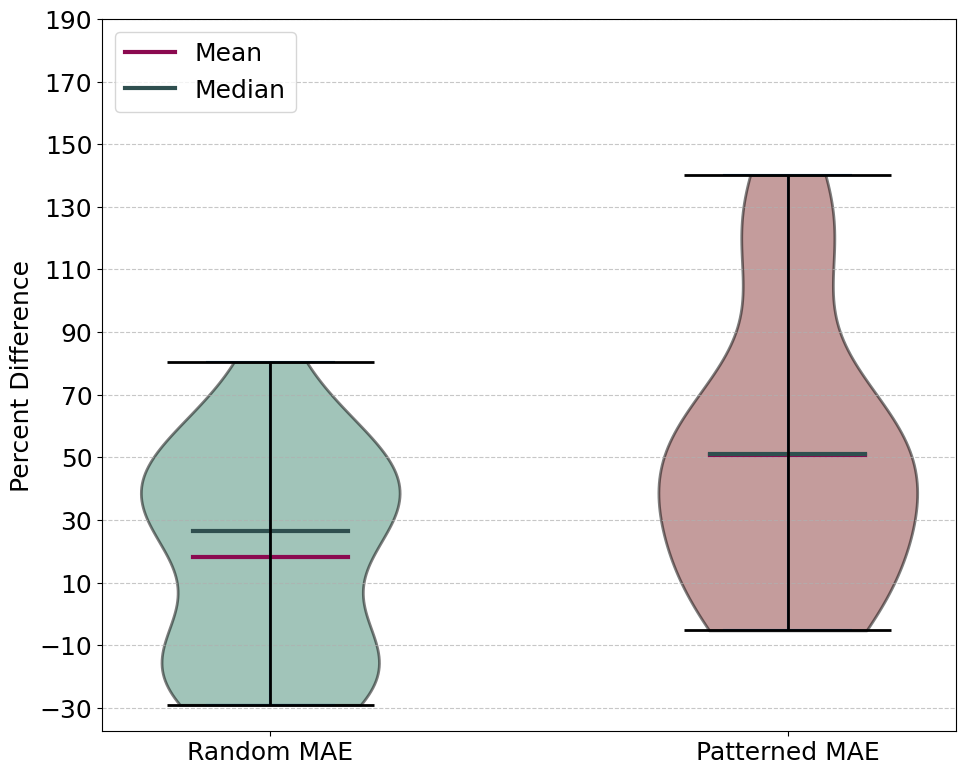

In [41]:
#Violin Plot

lookahead_list = [1,2,5,10,15]

r_mae_percent, r_rmse_percent, p_mae_percent, p_rmse_percent = [], [], [], []
for (res1, mae_data), (res2, rmse_data) in zip(mae_data_dict_full.items(), rmse_data_dict_full.items()):
    for lookahead in lookahead_list:
        for data_type in ['R', 'P']:
            if data_type == 'R':
                r_mae_percent.append(100 * (np.mean(mae_data[f"{lookahead} step"]['RUMP'][data_type]) - np.mean(
                    mae_data[f"{lookahead} step"]['HBPSHPO'][data_type])) / np.mean(
                    mae_data[f"{lookahead} step"]['HBPSHPO'][data_type]))
                r_rmse_percent.append(100 * (np.mean(rmse_data[f"{lookahead} step"]['RUMP'][data_type]) - np.mean(
                    rmse_data[f"{lookahead} step"]['HBPSHPO'][data_type])) / np.mean(
                    rmse_data[f"{lookahead} step"]['HBPSHPO'][data_type]))
            elif data_type == 'P':
                p_mae_percent.append(100 * (np.mean(mae_data[f"{lookahead} step"]['RUMP'][data_type]) - np.mean(
                    mae_data[f"{lookahead} step"]['HBPSHPO'][data_type])) / np.mean(
                    mae_data[f"{lookahead} step"]['HBPSHPO'][data_type]))
                p_rmse_percent.append(100 * (np.mean(rmse_data[f"{lookahead} step"]['RUMP'][data_type]) - np.mean(
                    rmse_data[f"{lookahead} step"]['HBPSHPO'][data_type])) / np.mean(
                    rmse_data[f"{lookahead} step"]['HBPSHPO'][data_type]))

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
plt.rcParams.update({'font.size': 18})

violin_plot_data = [r_mae_percent, p_mae_percent]#, r_rmse_percent, p_rmse_percent]
violin_plot_colors = ['#458B74', '#8B3A3A']#, '#aaffc3', '#FF6A6A']

vp = ax.violinplot(violin_plot_data)

for i, body in enumerate(vp['bodies']):
    body.set_facecolor(violin_plot_colors[i])
    body.set_edgecolor('black')
    body.set_linewidth(2)
    body.set_alpha(0.5)
    #change 

# Add mean and median lines
for i, data in enumerate(violin_plot_data):
    x = i + 1
    mean = np.mean(data)
    median = np.median(data)
    ax.plot([x - 0.15, x + 0.15], [mean, mean], color='#8B0A50', linestyle='-', linewidth=3)
    ax.plot([x - 0.15, x + 0.15], [median, median], color='#2F4F4F', linestyle='-', linewidth=3)

# Customize quartile lines
for i in range(len(violin_plot_data)):
    quartiles = np.percentile(violin_plot_data[i], [0.001, 99.999])
    ax.vlines(i + 1, quartiles[0], quartiles[1], color='black', linewidth=2)
    ax.hlines(quartiles, i + 1 - 0.2, i + 1 + 0.2, color='black', linewidth=2)

ax.set_xticks([1, 2])#, 3, 4])
ax.set_xticklabels(['Random MAE', 'Patterned MAE'])#, 'Random RMSE', 'Patterned RMSE'])
plt.ylabel('Percent Difference')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.yticks(np.arange(-30, 200, 20))

# Add annotations for the first violin chart
hbposhpo_annotation = 'HBPSHPO'
rump_annotation = 'RUMP'
first_violin_max = np.max(r_mae_percent)
first_violin_min = np.min(r_mae_percent)

# ax.annotate(hbposhpo_annotation, xy=(1, first_violin_max), xytext=(1.15, first_violin_max + 7),
#             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=7), fontsize=18)

# ax.annotate(rump_annotation, xy=(1, first_violin_min), xytext=(1.15, first_violin_min - 9),
#             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=7), fontsize=18)


# Add legend for median and mean lines
mean_line = plt.Line2D([], [], color='#8B0A50', linestyle='-', linewidth=3, label='Mean')
median_line = plt.Line2D([], [], color='#2F4F4F', linestyle='-', linewidth=3, label='Median')
plt.legend(handles=[mean_line, median_line], loc='upper left', fontsize=18)



plt.show()

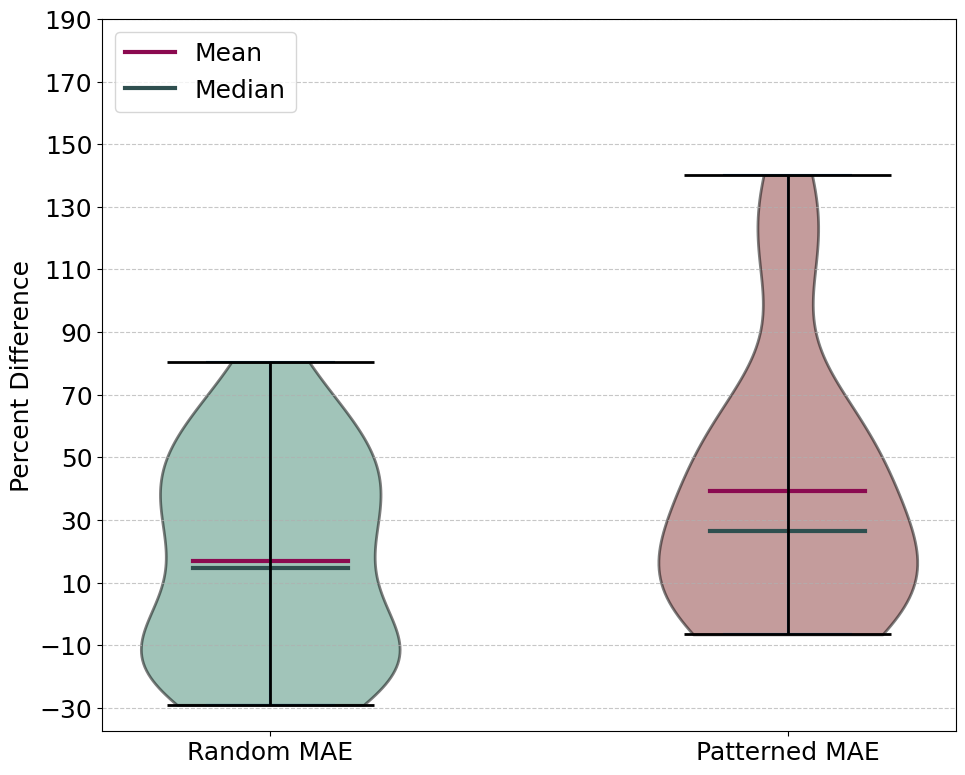

In [43]:
#Violin Plot

lookahead_list = [1,2,5,10,15, 30, 60]

r_mae_percent, r_rmse_percent, p_mae_percent, p_rmse_percent = [], [], [], []
for (res1, mae_data), (res2, rmse_data) in zip(mae_data_dict_full.items(), rmse_data_dict_full.items()):
    for lookahead in lookahead_list:
        for data_type in ['R', 'P']:
            if data_type == 'R':
                r_mae_percent.append(100 * (np.mean(mae_data[f"{lookahead} step"]['RUMP'][data_type]) - np.mean(
                    mae_data[f"{lookahead} step"]['HBPSHPO'][data_type])) / np.mean(
                    mae_data[f"{lookahead} step"]['HBPSHPO'][data_type]))
                r_rmse_percent.append(100 * (np.mean(rmse_data[f"{lookahead} step"]['RUMP'][data_type]) - np.mean(
                    rmse_data[f"{lookahead} step"]['HBPSHPO'][data_type])) / np.mean(
                    rmse_data[f"{lookahead} step"]['HBPSHPO'][data_type]))
            elif data_type == 'P':
                p_mae_percent.append(100 * (np.mean(mae_data[f"{lookahead} step"]['RUMP'][data_type]) - np.mean(
                    mae_data[f"{lookahead} step"]['HBPSHPO'][data_type])) / np.mean(
                    mae_data[f"{lookahead} step"]['HBPSHPO'][data_type]))
                p_rmse_percent.append(100 * (np.mean(rmse_data[f"{lookahead} step"]['RUMP'][data_type]) - np.mean(
                    rmse_data[f"{lookahead} step"]['HBPSHPO'][data_type])) / np.mean(
                    rmse_data[f"{lookahead} step"]['HBPSHPO'][data_type]))

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
plt.rcParams.update({'font.size': 18})

violin_plot_data = [r_mae_percent, p_mae_percent]#, r_rmse_percent, p_rmse_percent]
violin_plot_colors = ['#458B74', '#8B3A3A']#, '#aaffc3', '#FF6A6A']

vp = ax.violinplot(violin_plot_data)

for i, body in enumerate(vp['bodies']):
    body.set_facecolor(violin_plot_colors[i])
    body.set_edgecolor('black')
    body.set_linewidth(2)
    body.set_alpha(0.5)
    #change 

# Add mean and median lines
for i, data in enumerate(violin_plot_data):
    x = i + 1
    mean = np.mean(data)
    median = np.median(data)
    ax.plot([x - 0.15, x + 0.15], [mean, mean], color='#8B0A50', linestyle='-', linewidth=3)
    ax.plot([x - 0.15, x + 0.15], [median, median], color='#2F4F4F', linestyle='-', linewidth=3)

# Customize quartile lines
for i in range(len(violin_plot_data)):
    quartiles = np.percentile(violin_plot_data[i], [0.001, 99.999])
    ax.vlines(i + 1, quartiles[0], quartiles[1], color='black', linewidth=2)
    ax.hlines(quartiles, i + 1 - 0.2, i + 1 + 0.2, color='black', linewidth=2)

ax.set_xticks([1, 2])#, 3, 4])
ax.set_xticklabels(['Random MAE', 'Patterned MAE'])#, 'Random RMSE', 'Patterned RMSE'])
plt.ylabel('Percent Difference')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.yticks(np.arange(-30, 200, 20))

# Add annotations for the first violin chart
hbposhpo_annotation = 'HBPSHPO'
rump_annotation = 'RUMP'
first_violin_max = np.max(r_mae_percent)
first_violin_min = np.min(r_mae_percent)

# ax.annotate(hbposhpo_annotation, xy=(1, first_violin_max), xytext=(1.15, first_violin_max + 7),
#             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=7), fontsize=18)

# ax.annotate(rump_annotation, xy=(1, first_violin_min), xytext=(1.15, first_violin_min - 9),
#             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=7), fontsize=18)


# Add legend for median and mean lines
mean_line = plt.Line2D([], [], color='#8B0A50', linestyle='-', linewidth=3, label='Mean')
median_line = plt.Line2D([], [], color='#2F4F4F', linestyle='-', linewidth=3, label='Median')
plt.legend(handles=[mean_line, median_line], loc='upper left', fontsize=18)



plt.show()